In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, GroupKFold, LeaveOneGroupOut, StratifiedKFold
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import statsmodels.formula.api as smf
from tqdm import tqdm
import itertools
from sklearn.preprocessing import StandardScaler
import pickle

In [2]:
inDIR = '../data/training/'
inFILE = 'vor_2013_2022_cln_2023_08_29_plot_hls_idxs_test.csv'

inPATH = os.path.join(inDIR, inFILE)

lr_mod = pickle.load(open("../models/biomass/CPER_HLS_to_VOR_biomass_model_lr_simp.pk", 'rb'))

outDIR = './results/'

var_names = ['dfi', 'ndvi', 'ndti', 'satvi', 'ndii7', 
             'blue', 'green', 'red', 'nir', 'swir1', 'swir2',
             'bai_126', 'bai_136', 'bai_146', 'bai_236', 'bai_246', 'bai_346']

var_dict = {
    'NDVI': 'ndvi',
    'DFI': 'dfi',
    'NDTI': 'ndti',
    'SATVI': 'satvi',
    'NDII7': 'ndii7',
    'BAI_126': 'bai_126',
    'BAI_136': 'bai_136',
    'BAI_146': 'bai_146',
    'BAI_236': 'bai_236',
    'BAI_246': 'bai_246',
    'BAI_346': 'bai_346',
    'BLUE': 'blue',
    'GREEN': 'green',
    'RED': 'red',
    'NIR1': 'nir',
    'SWIR1': 'swir1',
    'SWIR2': 'swir2'
}

xv_vars = ['dfi', 'ndti', 'satvi', 'ndii7', 'swir1', 'swir2']
nsplits = 10

rand_st = 2313

In [3]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

def vip(x, y, model):
    t = model.x_scores_
    #w = model.x_weights_
    w = model.x_rotations_
    q = model.y_loadings_

    m, p = x.shape
    _, h = t.shape

    vips = np.zeros((p,))

    s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    total_s = np.sum(s)

    for i in range(p):
        weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
        vips[i] = np.sqrt(p*(s.T @ weight)/total_s)

    return vips

In [4]:
df_results = pd.read_csv(os.path.join(outDIR, "VOR_lreg_results.csv"))
df_results_full = pd.read_csv(os.path.join(outDIR, "VOR_lreg_results_full.csv"))

In [5]:
df_vor = pd.read_csv(inPATH, parse_dates=[2, 3])
df_vor = df_vor.rename(columns=var_dict)

In [6]:
df_vor = df_vor[df_vor['Season'].isin(['June', 'October'])].copy()
#df_vor = df_vor[df_vor['Year'] >= 2017].copy()

In [7]:
# check for any missing data
len(df_vor[df_vor[var_names].isnull().any(axis=1)])

0

In [8]:
# remove missing data
df_vor = df_vor[~df_vor[var_names].isnull().any(axis=1)].copy()
#df_vor = df_vor[~df_vor['Id'].isin(df_vor[df_vor[var_names].isnull().any(axis=1)]['Id'].unique())].copy()

In [9]:
X_vars_all = df_vor[var_names]
Y_var_all = df_vor['Biomass_kg_ha']

<AxesSubplot:>

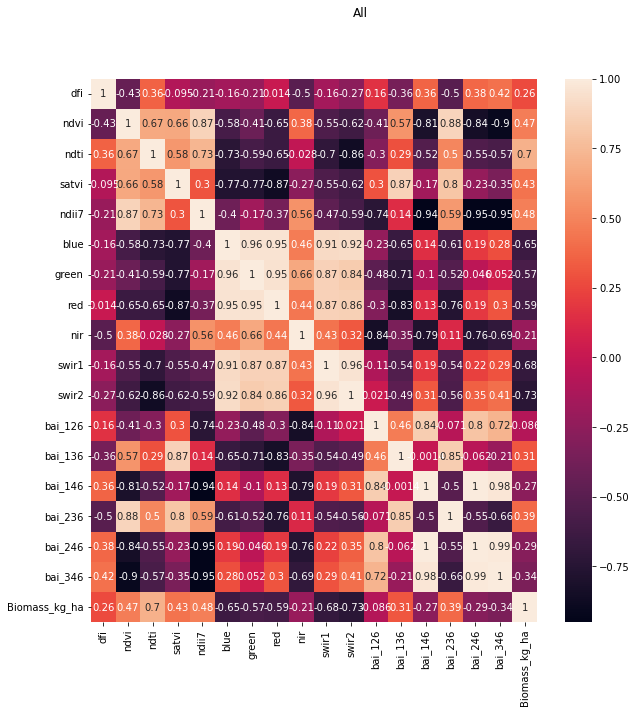

In [10]:
corrMatrix = X_vars_all.reset_index(drop=True).join(Y_var_all.reset_index(drop=True)).corr()
plt.figure(figsize=(10, 10))
plt.suptitle('All')
sns.heatmap(corrMatrix, annot=True)
#plt.show()

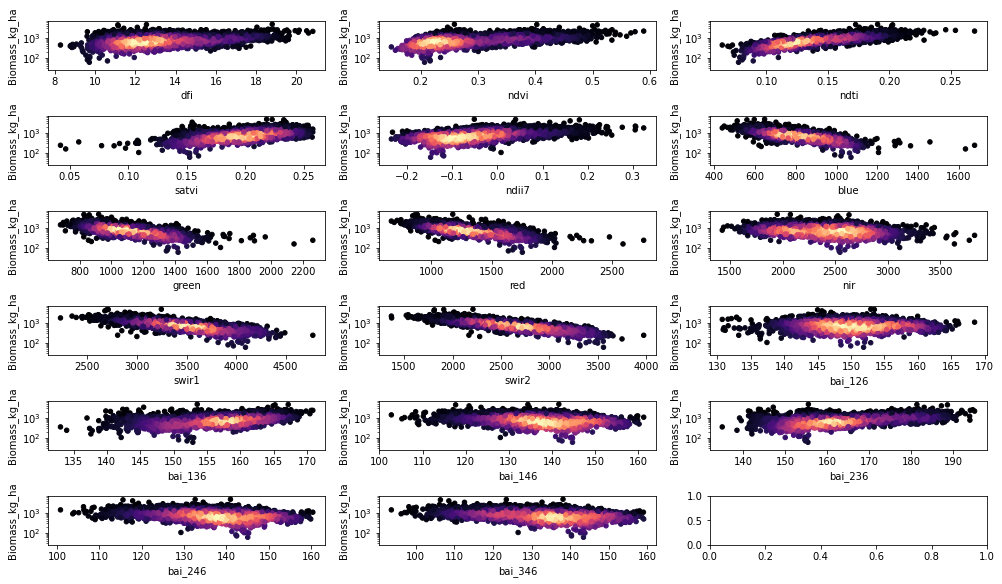

In [11]:
fig, axs = plt.subplots(figsize=(14, 8),
                        nrows=int(np.ceil(len(var_names) / 3)), ncols=3)
for idx, v in enumerate(var_names):
    xy_bm = np.vstack([df_vor[v], df_vor['Biomass_kg_ha']])
    z_bm = gaussian_kde(xy_bm)(xy_bm)
    df_vor.plot.scatter(x=v, y='Biomass_kg_ha', logy=True, ax=axs.flatten()[idx], ylim=(25, 7000),
                            c=z_bm, cmap='magma', colorbar=False)
    plt.tight_layout(pad=1.0)

In [20]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures

In [75]:
lr_form = df_results['formula'][413]

df_vor['bm_pred_lr_yr'] = np.nan
df_vor['bm_pred_lr_orig_yr'] = np.nan
df_vor['bm_pred_pls_yr'] = np.nan
df_vor['bm_pred_rf_yr'] = np.nan
df_vor['bm_pred_rft_yr'] = np.nan
df_vor['bm_pred_mlp_yr'] = np.nan
df_vor['bm_pred_svr_yr'] = np.nan

scaler = StandardScaler()
mod_logo = LeaveOneGroupOut()
mod_skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=rand_st)
scoring = {'R2': 'r2', 'MSE': 'neg_mean_squared_error', 'MAPE': 'neg_mean_absolute_percentage_error'}
param_grid = {
    'bootstrap': [True],
    'max_depth': [None],
    'max_features': [2, 4, 6, len(var_names)],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 5],
    'n_estimators': [500, 1000]
}

wtd = False
scale_vars = True

log_xfrm = True
log_xfrm_pls = False

pred_lr_2020 = True
fit_rf = False
fit_pls = True
fit_mlp = False
fit_svr = False

tune_rf = False
tune_pls = True
tune_pls_vip = False

intxn_ml = True
intxn_ml_poly = 2

mae_all_full_lr_ktests = []
mae_all_full_lr_orig_ktests = []
mae_pls_ktests = []
mae_tuned_ktests = []
mae_mlp_ktests = []
mae_all_full_ktests = []
mae_svr_ktests = []
n_comps = []
df_vip = pd.DataFrame(columns=['Year', 'Variable', 'VIP', 'Coef'])
for train_index, test_index in mod_logo.split(X_vars_all, groups=df_vor['Date'].dt.year, ):
    print("Running K-fold = " + str(df_vor['Date'].dt.year.iloc[test_index].unique()))
    
    all_y = Y_var_all.iloc[train_index]
    all_Y = Y_var_all.iloc[test_index]
    
    if wtd:
        lreg_tmp = smf.wls(formula=lr_form,
                           data=df_vor.iloc[train_index], weights=1 / df_vor.Biomass_kg_ha.iloc[train_index]).fit()
    else:
        lreg_tmp = smf.ols(formula=lr_form,
                           data=df_vor.iloc[train_index]).fit()
    if log_xfrm:
        see_tmp = np.sqrt(np.sum((np.log(df_vor['Biomass_kg_ha'].iloc[train_index]) -
                                  lreg_tmp.predict(df_vor.iloc[train_index])) ** 2) /
                          (len(train_index) - len(lreg_tmp.params)))
        cf_tmp = np.exp(see_tmp ** 2 / 2)  # correction factor from Sprugel 1983
        predictions_all_lr_tmp = np.exp(lreg_tmp.predict(df_vor.iloc[test_index]))# * cf_tmp
    else:
        predictions_all_lr_tmp = lreg_tmp.predict(df_vor.iloc[test_index])

    mae_all_full_lr_ktests.append(round(np.mean(np.abs(predictions_all_lr_tmp - all_Y)), 2))
    df_vor['bm_pred_lr_yr'].iloc[test_index] = predictions_all_lr_tmp

    if pred_lr_2020:
        predictions_lr_orig_tmp = np.exp(lr_mod.predict(df_vor.iloc[test_index]))
        df_vor['bm_pred_lr_orig_yr'].iloc[test_index] = predictions_lr_orig_tmp
        mae_all_full_lr_orig_ktests.append(round(np.mean(np.abs(predictions_lr_orig_tmp - all_Y)), 2))
        
    all_X = df_vor[var_names].iloc[test_index, :]
    all_x = df_vor[var_names].iloc[train_index, :]
    scaler.fit(all_x)
    
    if scale_vars:
        all_x = scaler.transform(all_x)
        all_X = scaler.transform(all_X)

    if intxn_ml:
        poly_x = PolynomialFeatures(degree=intxn_ml_poly, interaction_only=True, include_bias = False)
        all_x = poly_x.fit_transform(all_x)
        poly_X = PolynomialFeatures(degree=intxn_ml_poly, interaction_only=True, include_bias = False)
        all_X = poly_X.fit_transform(all_X)
    
    if fit_rf:
        rf_all_tmp = RandomForestRegressor(n_estimators=500, random_state=rand_st)
        rf_all_tmp.fit(all_x, all_y)
        predictions_all_tmp = rf_all_tmp.predict(all_X)
        mae_all_full_ktests.append(round(np.mean(np.abs(predictions_all_tmp - all_Y)), 2))
        df_vor['bm_pred_rf_yr'].iloc[test_index] = predictions_all_tmp
        
        if tune_rf:
            #rf_cv_all = mod_skf.split(all_x, df_vor['Year'].iloc[train_index])
            rf_cv_all = mod_logo.split(all_x, groups=df_vor['Date'].dt.year.iloc[train_index])
    
            # Create a base model
            rf_all_m1 = RandomForestRegressor(random_state=rand_st)
            # Instantiate the grid search model
            grid_search_all_m1 = GridSearchCV(estimator=rf_all_m1,
                                              param_grid=param_grid,
                                              scoring=scoring, 
                                              refit='MAPE', 
                                              return_train_score=True,
                                              cv=rf_cv_all, 
                                              n_jobs=-5, 
                                              verbose=0)
            grid_search_all_m1.fit(all_x, all_y)
            params_all_m1 = grid_search_all_m1.best_params_
            rf_all_m2 = RandomForestRegressor(n_estimators=params_all_m1['n_estimators'],
                                              min_samples_split=params_all_m1['min_samples_split'],
                                              min_samples_leaf=params_all_m1['min_samples_leaf'],
                                              max_features=params_all_m1['max_features'],
                                              bootstrap=params_all_m1['bootstrap'],
                                              max_depth=params_all_m1['max_depth'],
                                              random_state=rand_st)
            rf_all_m2.fit(all_x, all_y)
            # Use the forest's predict method on the test data
            predictions_all_tmp_m2 = rf_all_m2.predict(all_X)
            mae_tuned_ktests.append(round(np.mean(np.abs(predictions_all_tmp_m2 - all_Y)), 2))
            df_vor['bm_pred_rft_yr'].iloc[test_index] = predictions_all_tmp_m2
    if fit_mlp:
        mlp_all = MLPRegressor(solver='lbfgs', learning_rate='adaptive', max_iter=2000)
        mlp_all.fit(all_x, all_y)
        predictions_all_tmp_mlp = mlp_all.predict(all_X)
        mae_mlp_ktests.append(round(np.mean(np.abs(predictions_all_tmp_mlp - all_Y)), 2))
        df_vor['bm_pred_mlp_yr'].iloc[test_index] = predictions_all_tmp_mlp
    if fit_pls:
        if tune_pls:
            param_grid_pls = {'n_components': np.arange(1, len(var_names))}
            pls_cv_all = mod_logo.split(all_x, groups=df_vor['Date'].dt.year.iloc[train_index])
            
            # Create a base model
            pls_all_m1 = PLSRegression(scale=False)
            # Instantiate the grid search model
            grid_search_all_m1 = GridSearchCV(estimator=pls_all_m1,
                                              param_grid=param_grid_pls,
                                              scoring=scoring, 
                                              refit='MAPE', 
                                              return_train_score=True,
                                              cv=pls_cv_all, 
                                              n_jobs=5, 
                                              verbose=0)
            if log_xfrm_pls:
                grid_search_all_m1.fit(all_x, np.log(all_y))
            else:
                grid_search_all_m1.fit(all_x, all_y)
            params_all_m1 = grid_search_all_m1.best_params_
            n_comps.append(params_all_m1['n_components'])
            pls_all = PLSRegression(n_components=params_all_m1['n_components'])
        else:
            pls_all = PLSRegression(n_components=10)
        if log_xfrm_pls:
            pls_all.fit(all_x, np.log(all_y))
        else:
            pls_all.fit(all_x, all_y)
        
        if intxn_ml:
            var_names_out = poly_x.get_feature_names(var_names)
        else:
            var_names_out = var_names
        
        pls_vip = vip(all_x, all_y, pls_all)
        pls_coefs = abs(pls_all.coef_).squeeze()
        
        if tune_pls_vip:
            all_x_vip_adj = all_x[:, pls_vip > 1.0]
            all_X_vip_adj = all_X[:, pls_vip > 1.0]
            pls_all.fit(all_x_vip_adj, all_y)
            var_names_out = [x for idx, x in enumerate(var_names_out) if pls_vip[idx] > 1.0]
            pls_coefs = pls_coefs[pls_vip > 1.0]
            pls_vip = pls_vip[pls_vip > 1.0]
            
        else:
            all_X_vip_adj = all_X
        
        if log_xfrm_pls:
            see_tmp = np.sqrt(np.sum((np.log(df_vor['Biomass_kg_ha'].iloc[train_index]) -
                          pls_all.predict(all_x).squeeze()) ** 2) /
                  (all_x.shape[0] - all_x.shape[1]))
            cf_tmp = np.exp(see_tmp ** 2 / 2)  # correction factor from Sprugel 1983
            predictions_all_tmp_pls = np.exp(pls_all.predict(all_X_vip_adj).squeeze())# * cf_tmp
        else:
            predictions_all_tmp_pls = pls_all.predict(all_X_vip_adj).squeeze()
        
        predictions_all_tmp_pls[predictions_all_tmp_pls < 0.0] = 0.0
        mae_pls_ktests.append(round(np.mean(np.abs(predictions_all_tmp_pls - all_Y)), 2))
        df_vor['bm_pred_pls_yr'].iloc[test_index] = predictions_all_tmp_pls
        
        df_vip = pd.concat([df_vip,
                            pd.DataFrame({'Year': str(df_vor['Date'].dt.year.iloc[test_index].unique()[0]),
                                          'Variable': var_names_out,
                                          'VIP': pls_vip,
                                          'Coef': pls_coefs})])
    if fit_svr:
        svr_all = SVR()
        svr_all.fit(all_x, all_y)
        predictions_all_tmp_svr = svr_all.predict(all_X).squeeze()
        mae_svr_ktests.append(round(np.mean(np.abs(predictions_all_tmp_svr - all_Y)), 2))
        df_vor['bm_pred_svr_yr'].iloc[test_index] = predictions_all_tmp_svr

Running K-fold = [2013]


/tmp/ipykernel_14404/1734470356.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_lr_yr'].iloc[test_index] = predictions_all_lr_tmp
/tmp/ipykernel_14404/1734470356.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_lr_orig_yr'].iloc[test_index] = predictions_lr_orig_tmp
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/

Running K-fold = [2014]


/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
/tmp/ipykernel_14404/1734470356.py:197: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_pls_yr']

Running K-fold = [2015]


/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
/tmp/ipykernel_14404/1734470356.py:197: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_pls_yr']

Running K-fold = [2016]


/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
/tmp/ipykernel_14404/1734470356.py:197: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_pls_yr']

Running K-fold = [2017]


/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
/tmp/ipykernel_14404/1734470356.py:197: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_pls_yr']

Running K-fold = [2018]


/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
/tmp/ipykernel_14404/1734470356.py:197: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_pls_yr']

Running K-fold = [2019]


/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
/tmp/ipykernel_14404/1734470356.py:197: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_pls_yr']

Running K-fold = [2020]


/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
/tmp/ipykernel_14404/1734470356.py:197: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_pls_yr']

Running K-fold = [2021]


/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
/tmp/ipykernel_14404/1734470356.py:197: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_pls_yr']

Running K-fold = [2022]


/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
/tmp/ipykernel_14404/1734470356.py:197: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_pls_yr']

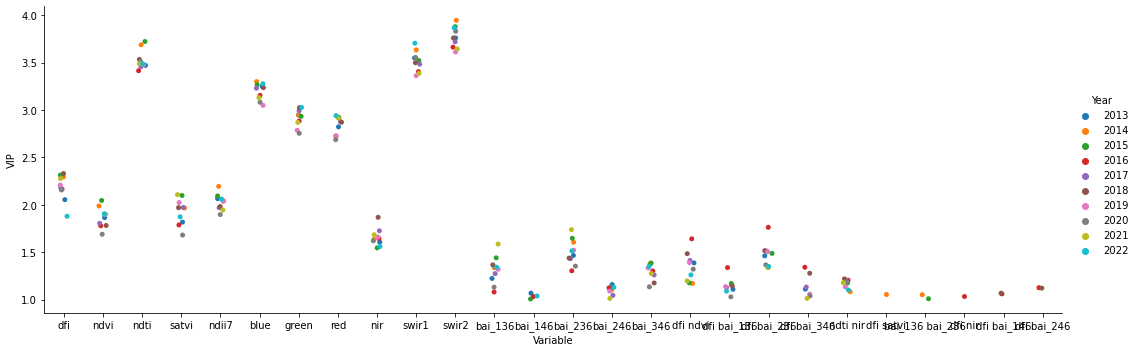

In [76]:
sns.catplot(df_vip[df_vip['VIP'] > 1.0], x='Variable', y='VIP', hue='Year', aspect=3)

In [80]:
df_vip[df_vip['VIP'] > 1.0].groupby('Variable')['VIP'].count().sort_values(ascending=False)#['Variable'].unique()

Variable
bai_136            10
green              10
swir1              10
satvi              10
red                10
nir                10
ndvi               10
ndti nir           10
ndti               10
ndii7              10
dfi ndvi           10
dfi bai_236        10
dfi                10
blue               10
bai_346            10
bai_236            10
swir2              10
dfi bai_136         9
bai_246             8
dfi bai_346         7
bai_146             4
dfi bai_246         2
bai_136 bai_236     2
dfi bai_146         2
dfi nir             1
dfi satvi           1
Name: VIP, dtype: int64

In [81]:
mod_dict = {
    'LR_orig': 'bm_pred_lr_orig_yr',
    'LR': 'bm_pred_lr_yr',
    'PLS': 'bm_pred_pls_yr'
}

In [82]:
df_vor['Pasture'] = df_vor['Id'].apply(lambda x: x.split('_')[0])
df_vor['Plot'] = df_vor['Id'].apply(lambda x: x.split('_')[1])
df_vor['Year'] = df_vor['Date'].dt.year

#### Transect-scale performance

In [83]:
if len(df_vor['Id'].iloc[0].split('_')) == 3:
    df_vor['Transect'] = df_vor['Id'].apply(lambda x: x.split('_')[-1])
    for k in mod_dict:
        print("----- " + k + " -----")
        print("MAE: " + 
              str(np.round(df_vor.groupby(['Pasture', 'Plot', 'Transect', 'Date']).apply(
                  lambda x: abs(np.mean(x[mod_dict[k]]) - np.mean(x['Biomass_kg_ha']))).mean() , 2)) + 
              " (sd = " +
              str(np.round(df_vor.groupby(['Pasture', 'Plot', 'Transect', 'Date']).apply(
                  lambda x: abs(np.mean(x[mod_dict[k]]) - np.mean(x['Biomass_kg_ha']))).std() , 2)) + 
              ") kg/ha")
        display(np.round(df_vor.groupby(['Pasture', 'Plot', 'Transect', 'Date', 'Year']).apply(
                  lambda x: np.mean(abs(x[mod_dict[k]] - x['Biomass_kg_ha']))).groupby(['Year']).mean() , 2))
        print("\nMAPE: " + 
              str(np.round(df_vor.groupby(['Pasture', 'Plot', 'Transect', 'Date']).apply(
                  lambda x: abs(np.mean(x[mod_dict[k]]) - np.mean(x['Biomass_kg_ha'])) / np.mean(x['Biomass_kg_ha'])).mean(), 2)) + 
              " (sd = " +
              str(np.round(df_vor.groupby(['Pasture', 'Plot', 'Transect', 'Date']).apply(
                  lambda x: abs(np.mean(x[mod_dict[k]]) - np.mean(x['Biomass_kg_ha'])) / np.mean(x['Biomass_kg_ha'])).std() , 2)) + 
              ") kg/ha")
        display(np.round(df_vor.groupby(['Pasture', 'Plot', 'Transect', 'Date', 'Year']).apply(
                  lambda x: abs(np.mean(x[mod_dict[k]]) - np.mean(x['Biomass_kg_ha'])) / np.mean(x['Biomass_kg_ha'])).groupby(['Year']).mean() , 2))
        print("\n\n")

#### Plot-scale performance

In [84]:
for k in mod_dict:
    print("----- " + k + " -----")
    print("MAE: " + 
          str(np.round(df_vor.groupby(['Pasture', 'Plot', 'Date']).apply(
              lambda x: abs(np.mean(x[mod_dict[k]]) - np.mean(x['Biomass_kg_ha']))).mean() , 2)) + 
          " (sd = " +
          str(np.round(df_vor.groupby(['Pasture', 'Plot', 'Date']).apply(
              lambda x: abs(np.mean(x[mod_dict[k]]) - np.mean(x['Biomass_kg_ha']))).std() , 2)) + 
          ") kg/ha")
    display(np.round(df_vor.groupby(['Pasture', 'Plot', 'Date', 'Year']).apply(
              lambda x: np.mean(abs(x[mod_dict[k]] - x['Biomass_kg_ha']))).groupby(['Year']).mean() , 2))
    print("\nMAPE: " + 
          str(np.round(df_vor.groupby(['Pasture', 'Plot', 'Date']).apply(
              lambda x: abs(np.mean(x[mod_dict[k]]) - np.mean(x['Biomass_kg_ha'])) / np.mean(x['Biomass_kg_ha'])).mean(), 2)) + 
          " (sd = " +
          str(np.round(df_vor.groupby(['Pasture', 'Plot', 'Date']).apply(
              lambda x: abs(np.mean(x[mod_dict[k]]) - np.mean(x['Biomass_kg_ha'])) / np.mean(x['Biomass_kg_ha'])).std() , 2)) + 
          ") kg/ha")
    display(np.round(df_vor.groupby(['Pasture', 'Plot', 'Date', 'Year']).apply(
              lambda x: abs(np.mean(x[mod_dict[k]]) - np.mean(x['Biomass_kg_ha'])) / np.mean(x['Biomass_kg_ha'])).groupby(['Year']).mean() , 2))
    print("\n\n")

----- LR_orig -----
MAE: 257.75 (sd = 280.57) kg/ha


Year
2013    240.39
2014    384.18
2015    237.85
2016    280.86
2017    209.81
2018    303.21
2019    226.38
2020    143.51
2021    334.61
2022    216.21
dtype: float64


MAPE: 0.29 (sd = 0.3) kg/ha


Year
2013    0.41
2014    0.29
2015    0.21
2016    0.23
2017    0.22
2018    0.30
2019    0.26
2020    0.31
2021    0.32
2022    0.44
dtype: float64




----- LR -----
MAE: 218.52 (sd = 238.95) kg/ha


Year
2013    200.22
2014    317.15
2015    320.15
2016    212.68
2017    194.47
2018    205.45
2019    184.99
2020    102.44
2021    269.08
2022    179.04
dtype: float64


MAPE: 0.26 (sd = 0.28) kg/ha


Year
2013    0.35
2014    0.27
2015    0.34
2016    0.18
2017    0.24
2018    0.20
2019    0.20
2020    0.22
2021    0.27
2022    0.35
dtype: float64




----- PLS -----
MAE: 241.69 (sd = 244.07) kg/ha


Year
2013    229.46
2014    309.84
2015    416.82
2016    219.55
2017    230.59
2018    208.18
2019    233.93
2020    116.19
2021    265.34
2022    190.55
dtype: float64


MAPE: 0.31 (sd = 0.33) kg/ha


Year
2013    0.46
2014    0.26
2015    0.45
2016    0.20
2017    0.30
2018    0.22
2019    0.27
2020    0.28
2021    0.27
2022    0.40
dtype: float64

Bad pipe message: %s [b'\xd5\ru\x05\xfeb\xc2\xb1`>\x8b\xd3\xd2h\xf4G\xd1\xd7\x00\x01p\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00A\x00B\x00C\x00D\x00E\x00F\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\xba\x00\xbb\x00\xbc\x00\xbd\x00\xbe\x00\xbf\x00\xc0\x00\xc1\x00\xc2\x00\xc3\x00\xc4\x00\xc5\x00\x9c\x00\x9d\x00\x9e\x00\x9f\x00\xa0\x00\xa1\x00\xa2\x00\xa3\x00\xa4\x00\xa5\x00\xa6\x00\xa7\xc0\x01\xc0\x02\xc0\x03\xc0\x04\xc0\x05\xc0\x06\xc0\x07\xc0\x08\xc0\t\xc0\n\xc0\x0b\xc0\x0c\xc0\r\xc0\x0e\xc0\x0f\xc0\x10\xc0\x11\xc0\x12\xc0\x13\xc0\x14\xc0\x15\xc0\x16\xc0\x17\xc0\x18\xc0\x19\xc0']
Bad pipe message: %s [b"$\xc0%\xc0&\xc0'\xc0(\xc0)\xc0*\xc0+\xc0,\xc0-\xc0.\xc0/\xc01\xc00\xc02\xc0s\xc0r\xc0

#### Pasture scale

In [64]:
for k in mod_dict:
    print("----- " + k + " -----")
    print("MAE: " + 
          str(np.round(df_vor.groupby(['Pasture', 'Date']).apply(
              lambda x: abs(np.mean(x[mod_dict[k]]) - np.mean(x['Biomass_kg_ha']))).mean() , 2)) + 
          " (sd = " +
          str(np.round(df_vor.groupby(['Pasture', 'Date']).apply(
              lambda x: abs(np.mean(x[mod_dict[k]]) - np.mean(x['Biomass_kg_ha']))).std() , 2)) + 
          ") kg/ha")
    display(np.round(df_vor.groupby(['Date', 'Pasture', 'Year']).apply(
              lambda x: np.mean(abs(x[mod_dict[k]] - x['Biomass_kg_ha']))).groupby(['Year']).mean() , 2))
    print("\nMAPE: " + 
          str(np.round(df_vor.groupby(['Pasture', 'Date']).apply(
              lambda x: abs(np.mean(x[mod_dict[k]]) - np.mean(x['Biomass_kg_ha'])) / np.mean(x['Biomass_kg_ha'])).mean(), 2)) + 
          " (sd = " +
          str(np.round(df_vor.groupby(['Pasture', 'Date']).apply(
              lambda x: abs(np.mean(x[mod_dict[k]]) - np.mean(x['Biomass_kg_ha'])) / np.mean(x['Biomass_kg_ha'])).std() , 2)) + 
          ") kg/ha")
    display(np.round(df_vor.groupby(['Date', 'Pasture', 'Year']).apply(
              lambda x: abs(np.mean(x[mod_dict[k]]) - np.mean(x['Biomass_kg_ha'])) / np.mean(x['Biomass_kg_ha'])).groupby(['Year']).mean() , 2))
    print('\n\n')

----- LR_orig -----
MAE: 253.82 (sd = 243.26) kg/ha


Year
2013    230.73
2014    364.36
2015    230.61
2016    273.29
2017    202.84
2018    356.07
2019    277.86
2020    154.76
2021    326.06
2022    232.74
dtype: float64


MAPE: 0.28 (sd = 0.23) kg/ha


Year
2013    0.41
2014    0.27
2015    0.16
2016    0.20
2017    0.20
2018    0.29
2019    0.29
2020    0.28
2021    0.30
2022    0.38
dtype: float64




----- LR -----
MAE: 191.65 (sd = 195.87) kg/ha


Year
2013    192.84
2014    306.01
2015    322.11
2016    208.09
2017    193.07
2018    230.88
2019    183.47
2020    108.61
2021    259.09
2022    192.42
dtype: float64


MAPE: 0.22 (sd = 0.21) kg/ha


Year
2013    0.32
2014    0.24
2015    0.30
2016    0.14
2017    0.20
2018    0.17
2019    0.18
2020    0.17
2021    0.24
2022    0.30
dtype: float64




----- PLS -----
MAE: 203.7 (sd = 194.11) kg/ha


Year
2013    238.16
2014    313.01
2015    369.68
2016    218.08
2017    228.82
2018    227.05
2019    156.20
2020    143.96
2021    257.70
2022    211.48
dtype: float64


MAPE: 0.25 (sd = 0.25) kg/ha


Year
2013    0.47
2014    0.27
2015    0.36
2016    0.15
2017    0.25
2018    0.17
2019    0.16
2020    0.25
2021    0.25
2022    0.34
dtype: float64

In [21]:
print("---- RF -----")
print("MAE: " + str(np.round(np.mean(mae_all_full_ktests), 2)) + " (sd = " +
      str(np.round(np.std(mae_all_full_ktests), 2)) + ") kg/ha")
print("MPE: " + str(np.round(np.mean(
    np.array(mae_all_full_ktests) / df_vor.groupby(df_vor['Date'].dt.year)['Biomass_kg_ha'].mean()), 2)))
print("MPE by year: ")
print(np.array(mae_all_full_ktests) / df_vor.groupby(df_vor['Date'].dt.year)['Biomass_kg_ha'].mean())

if tune_rf:
    print("---- RF Tuned -----")
    print("MAE: " + str(np.round(np.mean(mae_tuned_ktests), 2)) + " (sd = " +
          str(np.round(np.std(mae_tuned_ktests), 2)) + ") kg/ha")
    print("MPE: " + str(np.round(np.mean(
        np.array(mae_tuned_ktests) / df_vor.groupby(df_vor['Date'].dt.year)['Biomass_kg_ha'].mean()), 2)))
    print("MPE by year: ")
    print(np.array(mae_tuned_ktests) / df_vor.groupby(df_vor['Date'].dt.year)['Biomass_kg_ha'].mean())

print("---- LR -----")
print("MAE: " + str(np.round(np.mean(mae_all_full_lr_ktests), 2)) + " (sd = " +
      str(np.round(np.std(mae_all_full_lr_ktests), 2)) + ") kg/ha")
print("MPE: " + str(np.round(np.mean(
    np.array(mae_all_full_lr_ktests) / df_vor.groupby(df_vor['Date'].dt.year)['Biomass_kg_ha'].mean()), 2)))
print("MPE by year: ")
print(np.array(mae_all_full_lr_ktests) / df_vor.groupby(df_vor['Date'].dt.year)['Biomass_kg_ha'].mean())

if fit_mlp:
    print("---- MLP -----")
    print("MAE: " + str(np.round(np.mean(mae_mlp_ktests), 2)) + " (sd = " +
          str(np.round(np.std(mae_mlp_ktests), 2)) + ") kg/ha")
    print("MPE: " + str(np.round(np.mean(
        np.array(mae_mlp_ktests) / df_vor.groupby(df_vor['Date'].dt.year)['Biomass_kg_ha'].mean()), 2)))
    print("MPR by year: ")
    print(np.array(mae_mlp_ktests) / df_vor.groupby(df_vor['Date'].dt.year)['Biomass_kg_ha'].mean())

if fit_pls:
    print("---- PLS -----")
    print("MAE: " + str(np.round(np.mean(mae_pls_ktests), 2)) + " (sd = " +
          str(np.round(np.std(mae_pls_ktests), 2)) + ") kg/ha")
    print("MPE: " + str(np.round(np.mean(
        np.array(mae_pls_ktests) / df_vor.groupby(df_vor['Date'].dt.year)['Biomass_kg_ha'].mean()), 2)))
    print("MPE by year:")
    print(np.array(mae_pls_ktests) / df_vor.groupby(df_vor['Date'].dt.year)['Biomass_kg_ha'].mean())
if fit_svr:
    print("----- SVR -----")
    print("MAE: " + str(np.round(np.mean(mae_svr_ktests), 2)) + " (sd = " +
          str(np.round(np.std(mae_svr_ktests), 2)) + ") kg/ha")
    print("MPE: " + str(np.round(np.mean(
        np.array(mae_svr_ktests) / df_vor.groupby(df_vor['Date'].dt.year)['Biomass_kg_ha'].mean()), 2)))
    print("MPE by year: ")
    print(np.array(mae_svr_ktests) / df_vor.groupby(df_vor['Date'].dt.year)['Biomass_kg_ha'].mean())

---- RF -----
MAE: 275.32 (sd = 116.9) kg/ha
MPE: 0.3
MPE by year: 
Date
2013    0.359896
2014    0.258083
2015    0.491627
2016    0.255621
2017    0.238690
2018    0.291083
2019    0.214634
2020    0.225860
2021    0.304764
2022    0.396432
Name: Biomass_kg_ha, dtype: float64
---- LR -----
MAE: 243.4 (sd = 81.65) kg/ha
MPE: 0.27
MPE by year: 
Date
2013    0.285554
2014    0.281541
2015    0.253950
2016    0.333020
2017    0.201607
2018    0.261178
2019    0.210519
2020    0.203594
2021    0.294560
2022    0.365406
Name: Biomass_kg_ha, dtype: float64
---- MLP -----
MAE: 443.39 (sd = 259.4) kg/ha
MPE: 0.5
MPR by year: 
Date
2013    0.800664
2014    0.338698
2015    0.993033
2016    0.324572
2017    0.330301
2018    0.312530
2019    0.322959
2020    0.437076
2021    0.498130
2022    0.607269
Name: Biomass_kg_ha, dtype: float64
---- PLS -----
MAE: 243.98 (sd = 70.69) kg/ha
MPE: 0.28
MPE by year:
Date
2013    0.325358
2014    0.256820
2015    0.302267
2016    0.234094
2017    0.208185
201

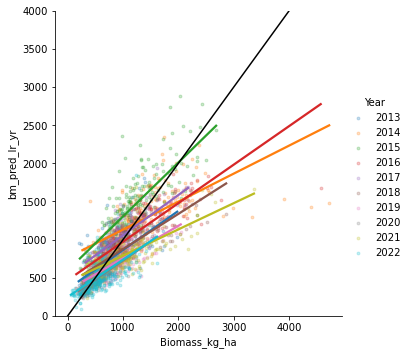

In [65]:
import seaborn as sns
p = sns.lmplot(df_vor, x='Biomass_kg_ha', y='bm_pred_lr_yr', hue='Year', ci=None, scatter_kws={'s': 8, 'alpha': 0.25})
p.axes[0, 0].set_ylim((0, 4000))
p.axes[0, 0].plot(np.arange(0, 4000), np.arange(0, 4000), c='black')

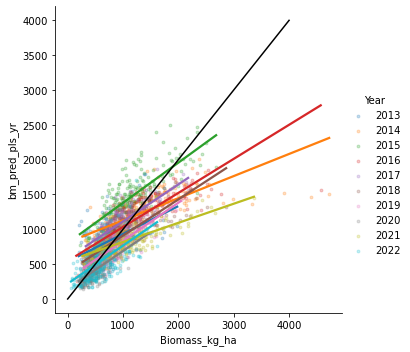

In [66]:
p2 = sns.lmplot(df_vor, x='Biomass_kg_ha', y='bm_pred_pls_yr', hue='Year', ci=None, scatter_kws={'s': 8, 'alpha': 0.25})
p2.axes[0, 0].plot(np.arange(0, 4000), np.arange(0, 4000), c='black')

In [52]:
df_vor[(df_vor['Year'] == 2014) & (df_vor['bm_pred_pls_yr'] > 2000)]

,Id,Pasture,Date,Date_mean,Year,Season,Low,High,Biomass_kg_ha,geometry,...,swir1,swir2,bm_pred_rf_yr,bm_pred_rft_yr,bm_pred_lr_yr,bm_pred_mlp_yr,bm_pred_pls_yr,bm_pred_svr_yr,Plot,Transect
8097,17N_P3_4,17N,2022-06-06,2022-06-05,2022,June,7.81,24.38,1654,"POLYGON ((526232.6245117188 4520611.770690918,...",...,2764.538462,1723.282135,2429.542,NaN,2365.786125,NaN,2008.645701,NaN,P3,4
8198,17S_P4_2,17S,2022-06-08,2022-06-07,2022,June,6.75,24.00,1503,"POLYGON ((526409.0256958008 4520131.959289551,...",...,2651.539918,1694.446970,2467.506,NaN,2797.141792,NaN,2276.334601,NaN,P4,2
8830,17N_P6_2,17N,2022-10-05,2022-10-05,2022,October,2.25,18.19,764,"POLYGON ((527019.3674926758 4520524.777099609,...",...,2373.682318,1616.942058,1525.886,NaN,2583.343462,NaN,2469.138082,NaN,P6,2
8831,17N_P6_1,17N,2022-10-05,2022-10-05,2022,October,2.00,19.93,772,"POLYGON ((526913.3175048828 4520524.777099609,...",...,2643.915584,1987.357143,1678.524,NaN,1614.447121,NaN,2269.597060,NaN,P6,1
8848,17N_P4_1,17N,2022-10-05,2022-10-05,2022,October,5.75,28.12,1467,"POLYGON ((526170.6746826172 4520822.225097656,...",...,2466.761405,1548.479021,1876.012,NaN,2644.540591,NaN,2289.617595,NaN,P4,1
8850,17N_P3_4,17N,2022-10-05,2022-10-05,2022,October,6.69,31.56,1674,"POLYGON ((526232.6245117188 4520611.770690918,...",...,2379.108725,1419.903596,2350.276,NaN,3043.028653,NaN,2466.072853,NaN,P3,4
8906,17N_P6_3,17N,2022-10-05,2022-10-05,2022,October,0.94,17.75,579,"POLYGON ((526913.3175048828 4520628.777099609,...",...,2577.088079,1981.028139,1703.724,NaN,1591.829570,NaN,2610.166443,NaN,P6,3
8908,17N_P6_4,17N,2022-10-05,2022-10-05,2022,October,2.81,23.06,954,"POLYGON ((527019.3674926758 4520628.777099609,...",...,1995.839993,1278.668165,2158.672,NaN,5714.617277,NaN,3957.752392,NaN,P6,4
8921,17S_P4_2,17S,2022-10-05,2022-10-05,2022,October,4.06,19.06,1027,"POLYGON ((526409.0256958008 4520131.959289551,...",...,2052.677656,1270.078422,2461.874,NaN,3708.391047,NaN,3032.205528,NaN,P4,2
8931,20SE_P4_2,20SE,2022-10-05,2022-10-05,2022,October,3.19,25.69,1067,"POLYGON ((526996.1342773438 4518571.303894043,...",...,2465.866467,1700.618215,2232.356,NaN,2466.746040,NaN,2479.412844,NaN,P4,2


In [68]:
df_vor[(df_vor['Year'] == 2014) & (df_vor['Biomass_kg_ha'] > 3000)]

,Id,Pasture,Date,Date_mean,Year,Season,Low,High,Biomass_kg_ha,geometry,...,swir1,swir2,bm_pred_lr_yr,bm_pred_lr_orig_yr,bm_pred_pls_yr,bm_pred_rf_yr,bm_pred_rft_yr,bm_pred_mlp_yr,bm_pred_svr_yr,Plot
183,17S_P6,17S,2014-06-12,2014-06-12,2014,June,21.90,60.85,4400,"POLYGON ((526894.4512939453 4520057.735717773,...",...,2693.056294,1812.249750,1426.102520,1058.457502,1456.954216,NaN,NaN,NaN,NaN,P6
209,5E_P4,5E,2014-06-12,2014-06-12,2014,June,18.44,34.81,3321,"POLYGON ((526538.3131103516 4523404.554321289,...",...,2926.543787,2010.897269,1291.072134,1021.913279,1369.397923,NaN,NaN,NaN,NaN,P4
235,20SE_P2,20SE,2014-06-12,2014-06-12,2014,June,20.08,50.48,3911,"POLYGON ((526459.3098754883 4518153.165527344,...",...,2675.898139,1808.330116,1537.877355,1129.885041,1527.676798,NaN,NaN,NaN,NaN,P2
310,17S_P6,17S,2014-10-05,2014-10-05,2014,October,23.30,66.58,4723,"POLYGON ((526894.4512939453 4520057.735717773,...",...,3245.221380,2211.187639,1481.211516,1473.126479,1506.857830,NaN,NaN,NaN,NaN,P6


In [24]:
df_vor['Id_plot'] = df_vor['Id'].apply(lambda x: '_'.join(x.split('_')[:-1]))

In [25]:
ae_plot_rf = abs(df_vor.groupby(['Id_plot', 'Date'])['bm_pred_rf_yr'].mean() - \
df_vor.groupby(['Id_plot', 'Date'])['Biomass_kg_ha'].mean())
pe_plot_rf = ae_plot_rf / \
df_vor.groupby(['Id_plot', 'Date'])['Biomass_kg_ha'].mean()

ae_plot_rft = abs(df_vor.groupby(['Id_plot', 'Date'])['bm_pred_rft_yr'].mean() - \
df_vor.groupby(['Id_plot', 'Date'])['Biomass_kg_ha'].mean())
pe_plot_rft = ae_plot_rft / \
df_vor.groupby(['Id_plot', 'Date'])['Biomass_kg_ha'].mean()

ae_plot_lr = abs(df_vor.groupby(['Id_plot', 'Date'])['bm_pred_lr_yr'].mean() - \
df_vor.groupby(['Id_plot', 'Date'])['Biomass_kg_ha'].mean())
pe_plot_lr = ae_plot_lr / \
df_vor.groupby(['Id_plot', 'Date'])['Biomass_kg_ha'].mean()

ae_plot_pls = abs(df_vor.groupby(['Id_plot', 'Date'])['bm_pred_pls_yr'].mean() - \
df_vor.groupby(['Id_plot', 'Date'])['Biomass_kg_ha'].mean())
pe_plot_pls = ae_plot_pls / \
df_vor.groupby(['Id_plot', 'Date'])['Biomass_kg_ha'].mean()

ae_plot_svr = abs(df_vor.groupby(['Id_plot', 'Date'])['bm_pred_svr_yr'].mean() - \
df_vor.groupby(['Id_plot', 'Date'])['Biomass_kg_ha'].mean())
pe_plot_svr = ae_plot_svr / \
df_vor.groupby(['Id_plot', 'Date'])['Biomass_kg_ha'].mean()

ae_plot_mlp = abs(df_vor.groupby(['Id_plot', 'Date'])['bm_pred_mlp_yr'].mean() - \
df_vor.groupby(['Id_plot', 'Date'])['Biomass_kg_ha'].mean())
pe_plot_mlp = ae_plot_mlp / \
df_vor.groupby(['Id_plot', 'Date'])['Biomass_kg_ha'].mean()

In [26]:
print("---- RF -----")
print("MAE: " + str(np.round(np.mean(ae_plot_rf), 2)) + " (sd = " +
      str(np.round(np.std(abs(ae_plot_rf)), 2)) + ") kg/ha")
print("MPE: " + str(np.round(np.mean(pe_plot_rf), 2)))
print("MPE by year: ")
print(pd.Series(pe_plot_rf, name='PE').reset_index().groupby(
    df_vor.groupby(['Id_plot', 'Date']).first().reset_index()['Date'].dt.year)['PE'].mean())

if tune_rf:
    print("----- RF Tuned -----")
    print("MAE: " + str(np.round(np.mean(ae_plot_rft), 2)) + " (sd = " +
      str(np.round(np.std(abs(ae_plot_rft)), 2)) + ") kg/ha")
    print("MPE: " + str(np.round(np.mean(pe_plot_rft), 2)))
    print("MPE by year: ")
    print(pd.Series(pe_plot_rft, name='PE').reset_index().groupby(
        df_vor.groupby(['Id_plot', 'Date']).first().reset_index()['Date'].dt.year)['PE'].mean())

print("---- LR -----")
print("MAE: " + str(np.round(np.mean(ae_plot_lr), 2)) + " (sd = " +
      str(np.round(np.std(abs(ae_plot_lr)), 2)) + ") kg/ha")
print("MPE: " + str(np.round(np.mean(pe_plot_lr), 2)))
print("MPE by year: ")
print(pd.Series(pe_plot_lr, name='PE').reset_index().groupby(
    df_vor.groupby(['Id_plot', 'Date']).first().reset_index()['Date'].dt.year)['PE'].mean())

print("---- PLS -----")
print("MAE: " + str(np.round(np.mean(ae_plot_pls), 2)) + " (sd = " +
      str(np.round(np.std(abs(ae_plot_pls)), 2)) + ") kg/ha")
print("MPE: " + str(np.round(np.mean(pe_plot_pls), 2)))
print("MPE by year: ")
print(pd.Series(pe_plot_pls, name='PE').reset_index().groupby(
    df_vor.groupby(['Id_plot', 'Date']).first().reset_index()['Date'].dt.year)['PE'].mean())

print("---- SVR -----")
print("MAE: " + str(np.round(np.mean(ae_plot_svr), 2)) + " (sd = " +
      str(np.round(np.std(abs(ae_plot_svr)), 2)) + ") kg/ha")
print("MPE: " + str(np.round(np.mean(pe_plot_svr), 2)))
print("MPE by year: ")
print(pd.Series(pe_plot_svr, name='PE').reset_index().groupby(
    df_vor.groupby(['Id_plot', 'Date']).first().reset_index()['Date'].dt.year)['PE'].mean())

print("---- MLP -----")
print("MAE: " + str(np.round(np.mean(ae_plot_mlp), 2)) + " (sd = " +
      str(np.round(np.std(abs(ae_plot_mlp)), 2)) + ") kg/ha")
print("MPE: " + str(np.round(np.mean(pe_plot_mlp), 2)))
print("MPE by year: ")
print(pd.Series(pe_plot_mlp, name='PE').reset_index().groupby(
    df_vor.groupby(['Id_plot', 'Date']).first().reset_index()['Date'].dt.year)['PE'].mean())

---- RF -----
MAE: 234.9 (sd = 252.71) kg/ha
MPE: 0.28
MPE by year: 
Date
2013    0.407563
2014    0.248434
2015    0.534509
2016    0.215062
2017    0.206374
2018    0.261374
2019    0.175111
2020    0.184585
2021    0.261642
2022    0.412059
Name: PE, dtype: float64
---- LR -----
MAE: 218.26 (sd = 417.16) kg/ha
MPE: 0.25
MPE by year: 
Date
2013    0.327998
2014    0.253748
2015    0.276687
2016    0.359483
2017    0.179552
2018    0.226682
2019    0.168870
2020    0.165710
2021    0.264508
2022    0.374390
Name: PE, dtype: float64
---- PLS -----
MAE: 212.04 (sd = 214.57) kg/ha
MPE: 0.26
MPE by year: 
Date
2013    0.433150
2014    0.240233
2015    0.348858
2016    0.204872
2017    0.188831
2018    0.257418
2019    0.146633
2020    0.196634
2021    0.264330
2022    0.415918
Name: PE, dtype: float64
---- SVR -----
MAE: 274.11 (sd = 268.81) kg/ha
MPE: 0.37
MPE by year: 
Date
2013    0.507612
2014    0.364209
2015    0.289002
2016    0.280591
2017    0.198207
2018    0.289942
2019    0.21

In [27]:
df_vor_grp = df_vor.groupby(['Id_plot', 'Date']).mean().reset_index()

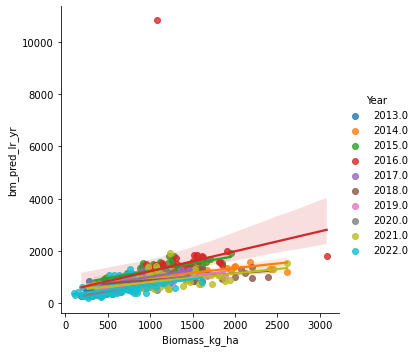

In [28]:
import seaborn as sns
sns.lmplot(df_vor_grp, x='Biomass_kg_ha', y='bm_pred_lr_yr', hue='Year')

In [29]:
df_vor_grp['Id_pasture'] = df_vor['Id_plot'].apply(lambda x: '_'.join(x.split('_')[0]))

In [30]:
df_vor_pasture = df_vor_grp.groupby(['Id_pasture', 'Date']).mean().reset_index()

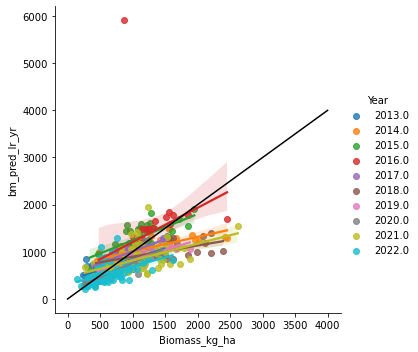

In [31]:
import seaborn as sns
p = sns.lmplot(df_vor_pasture, x='Biomass_kg_ha', y='bm_pred_lr_yr', hue='Year')
p.axes[0, 0].plot(np.arange(0, 4000), np.arange(0, 4000), c='black')

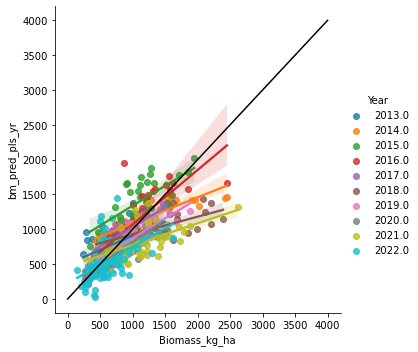

In [32]:
p2 = sns.lmplot(df_vor_pasture, x='Biomass_kg_ha', y='bm_pred_pls_yr', hue='Year')
p2.axes[0, 0].plot(np.arange(0, 4000), np.arange(0, 4000), c='black')